In [ ]:
import pickle
import pandas as pd
import os

# โหลดโมเดล Random Forest
model_path = "random_forest_model.pkl"  # ระบุพาธของไฟล์โมเดล
if os.path.exists(model_path):
    with open(model_path, "rb") as file:
        rf_model = pickle.load(file)
else:
    raise FileNotFoundError(f"File not found: {model_path}")

# โหลดไฟล์ข้อมูล CSV
data_file_path = "newsest_data.csv"  # ระบุพาธของไฟล์ข้อมูล
df = pd.read_csv(data_file_path)

# ตรวจสอบโครงสร้างของข้อมูล
print(df.head())

# เลือกเฉพาะคอลัมน์ที่ใช้เป็น Features สำหรับการพยากรณ์
feature_columns = [col for col in df.columns if col not in ["Time", "PV_no"]]  # ลบคอลัมน์ที่ไม่ใช้
X_test = df[feature_columns]

# ตรวจสอบค่า NaN และจัดการ (ถ้ามี)
X_test = X_test.dropna()

# ทำการพยากรณ์
predictions = rf_model.predict(X_test)

# เพิ่มผลลัพธ์เข้าไปใน DataFrame
df.loc[X_test.index, "Predicted_Output"] = predictions

# บันทึกผลลัพธ์
df.to_csv("predicted_results.csv", index=False)

print("บันทึกผลลัพธ์แล้วที่ predicted_results.csv")


TypeError: Loaded object is not a valid model

In [141]:
# from statsmodels.tsa.arima.model import ARIMA

# # สร้าง DataFrame เพื่อใช้กับ ARIMA
# future_predictions_arima = {}

# for pv in df_grouped['PV_no.'].unique():
#     df_pv = df_grouped[df_grouped['PV_no.'] == pv][['Date', 'Anomaly_Label']].set_index('Date')

#     # สร้างและฝึกโมเดล ARIMA
#     model = ARIMA(df_pv, order=(5,1,0))  # ใช้ค่า order เบื้องต้น
#     model_fit = model.fit()

#     # ทำนายข้อมูลอนาคต 30 วัน
#     forecast = model_fit.forecast(steps=30)

#     # สร้าง DataFrame สำหรับผลลัพธ์การทำนาย
#     forecast_dates = pd.date_range(start=df_pv.index[-1], periods=31, freq='D')[1:]
#     forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted_Anomaly': forecast.values})

#     # เก็บผลลัพธ์
#     future_predictions_arima[pv] = forecast_df

#     # แสดงกราฟพยากรณ์
#     plt.figure(figsize=(12, 6))
#     plt.plot(df_pv.index, df_pv['Anomaly_Label'], label='Actual', marker='o')
#     plt.plot(forecast_df['Date'], forecast_df['Predicted_Anomaly'], label='Predicted', linestyle='dashed', color='red')
#     plt.xlabel('Date')
#     plt.ylabel('Anomaly Count')
#     plt.title(f'Anomaly Forecast for PV_no. {pv} (ARIMA)')
#     plt.legend()
#     plt.grid()
#     plt.show()

# # รวมผลลัพธ์ทั้งหมดไว้ใน DataFrame
# df_predictions_arima = pd.concat([df.assign(PV_no=pv) for pv, df in future_predictions_arima.items()])



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# โหลดข้อมูล
df_pv3 = pd.read_csv("forlearnpredic.csv")

# เลือกเฉพาะข้อมูลของ PV_no = 3
df_pv3 = df_pv3[df_pv3["PV_no."] == 3].copy()

# รีเซ็ต index
df_pv3 = df_pv3.drop(columns=["Unnamed: 0", "PV_no."], errors="ignore").reset_index(drop=True)

# แปลงคอลัมน์ Date เป็น datetime
df_pv3["Date"] = pd.to_datetime(df_pv3["Date"])

# ปรับขนาดข้อมูลด้วย MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_pv3.drop(columns=["Date", "Anomaly_Label"]))

# สร้างข้อมูลสำหรับ LSTM (ใช้ time step = 10)
time_steps = 10
X_train_lstm, y_train_lstm = [], []

for i in range(len(X_scaled) - time_steps):
    X_train_lstm.append(X_scaled[i : i + time_steps])
    y_train_lstm.append(df_pv3["Anomaly_Label"].iloc[i + time_steps])

X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)

# กำหนดโมเดล LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation="relu"),
    Dense(units=1, activation="linear")  # ใช้ linear output สำหรับ anomaly score
])

# คอมไพล์โมเดล
model.compile(optimizer="adam", loss="mse")

# ฝึกโมเดล
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, validation_split=0.2, verbose=1)

# บันทึกโมเดล
model.save("lstm_pv3_model.h5")

print("โมเดลถูกบันทึกเป็น 'lstm_pv3_model.h5'")


Epoch 1/20


c:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 353.0345 - val_loss: 220.8637
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 239.0971 - val_loss: 84.2791
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 137.6740 - val_loss: 39.2587
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 87.9622 - val_loss: 41.4812
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 89.8534 - val_loss: 41.7933
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 89.9751 - val_loss: 38.8817
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 91.9053 - val_loss: 39.1939
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.4873 - val_loss: 38.9792
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 83.6135 - val_loss: 39.4145
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.5576 - val_loss: 39.4621
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 86.8123 - val_loss: 39.3451
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

โมเดลถูกบันทึกเป็น 'lstm_pv3_model.h5'


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# โหลดโมเดลโดยกำหนด custom_objects
model = tf.keras.models.load_model("lstm_pv3_model.h5", custom_objects={"mse": tf.keras.losses.MeanSquaredError()})

# โหลดข้อมูลใหม่ที่ต้องการทำนาย
df_test = pd.read_csv("newsest _data.csv")

# เลือกเฉพาะข้อมูลของ PV_no = 3
df_test_pv3 = df_test[df_test["PV_no."] == 3].copy()

# ลบคอลัมน์ที่ไม่จำเป็น
df_test_pv3 = df_test_pv3.drop(columns=["Unnamed: 0", "PV_no."], errors="ignore").reset_index(drop=True)

# เปลี่ยนชื่อคอลัมน์ Time.1 เป็น Date
df_test_pv3.rename(columns={"Time.1": "Date"}, inplace=True)

# แปลงคอลัมน์ Date เป็น datetime
df_test_pv3["Date"] = pd.to_datetime(df_test_pv3["Date"])

# ปรับขนาดข้อมูลด้วย MinMaxScaler (ใช้ scaler เดิมที่ใช้ตอนเทรน)
scaler = MinMaxScaler()
X_scaled_test = scaler.fit_transform(df_test_pv3.drop(columns=["Date"]))

# สร้างข้อมูลที่เหมาะสมกับ LSTM (ใช้ time step = 10)
time_steps = 10
X_test_lstm = []

for i in range(len(X_scaled_test) - time_steps):
    X_test_lstm.append(X_scaled_test[i : i + time_steps])

X_test_lstm = np.array(X_test_lstm)

# ทำการพยากรณ์ anomaly score
predictions = model.predict(X_test_lstm)

# เพิ่มผลลัพธ์เข้าไปใน DataFrame
df_test_pv3 = df_test_pv3.iloc[time_steps:].copy()  # ตัดแถวแรกออกให้ตรงกับ time steps
df_test_pv3["Anomaly_Score"] = predictions

# บันทึกผลลัพธ์
df_test_pv3.to_csv("predicted_anomalies.csv", index=False)

print("บันทึกผลลัพธ์แล้วที่ predicted_anomalies.csv")

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 6 and 5 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_1, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,6], [5,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 6), dtype=float32)
  • states=('tf.Tensor(shape=(32, 50), dtype=float32)', 'tf.Tensor(shape=(32, 50), dtype=float32)')
  • training=False

In [147]:
from tensorflow.keras.models import load_model
import tensorflow as tf

model = load_model("lstm_anomaly_model.h5", custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
print("✅ โหลดโมเดลสำเร็จ!")


✅ โหลดโมเดลสำเร็จ!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

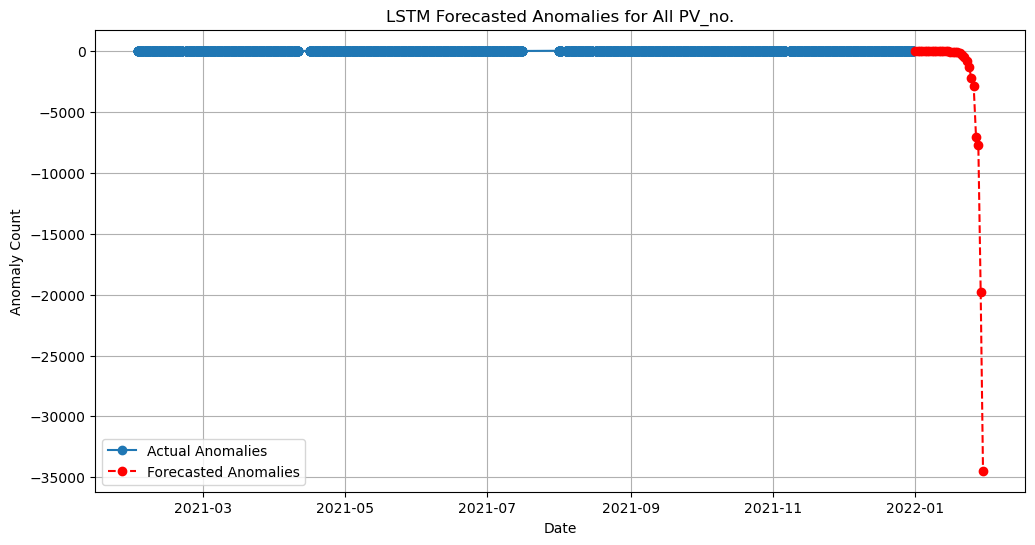

InvalidArgumentError: Graph execution error:

Detected at node sequential_167_1/lstm_314_1/while/body/_1/sequential_167_1/lstm_314_1/while/lstm_cell_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,5], In[1]: [11,200]
	 [[{{node sequential_167_1/lstm_314_1/while/body/_1/sequential_167_1/lstm_314_1/while/lstm_cell_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_1447112]

In [154]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt

# โหลดข้อมูล
df = pd.read_csv('forlearnpredic.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# โหลดโมเดลที่ฝึกไว้

model = load_model("lstm_anomaly_model.h5", custom_objects={'mse': tf.keras.losses.MeanSquaredError()})

# แปลง PV_no. เป็น One-Hot Encoding
pv_encoder = OneHotEncoder(sparse_output=False)
pv_encoded = pv_encoder.fit_transform(df[['PV_no.']])

# ปรับขนาดค่า Anomaly_Label
scaler = MinMaxScaler()
df['Anomaly_Label'] = scaler.fit_transform(df[['Anomaly_Label']])

# รวมฟีเจอร์ PV_no. และ Anomaly_Label เป็น Input
features = np.hstack((pv_encoded, df[['Anomaly_Label']].values))

# ฟังก์ชันสร้างชุดข้อมูลสำหรับ LSTM
def create_sequences(data, seq_length=10):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

seq_length = 10
future_steps = 30

# สร้างชุดข้อมูลจากข้อมูลล่าสุด
X_last = create_sequences(features, seq_length)[-1].reshape(1, seq_length, features.shape[1])

# พยากรณ์ข้อมูลในอนาคต
temp_input = X_last
predictions = []

for _ in range(future_steps):
    pred = model.predict(temp_input)[0]
    predictions.append(pred)
    temp_input = np.append(temp_input[:, 1:, :], np.hstack((pv_encoded[-1].reshape(1, -1), np.array(pred).reshape(1, 1))).reshape(1, 1, -1), axis=1)

# แปลงค่ากลับเป็นขนาดจริง
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# สร้าง DataFrame สำหรับผลลัพธ์
dates_future = pd.date_range(df.index[-1], periods=future_steps+1, freq='D')[1:]
df_predictions_lstm = pd.DataFrame({'Date': dates_future, 'Predicted_Anomaly': predictions.flatten()})

# แสดงผลลัพธ์
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df[['Anomaly_Label']]), label='Actual Anomalies', marker='o')
plt.plot(dates_future, predictions, label='Forecasted Anomalies', linestyle='dashed', marker='o', color='red')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.title('LSTM Forecasted Anomalies for All PV_no.')
plt.legend()
plt.grid()
plt.show()

# ทำนาย anomaly
predicted_anomaly = model.predict(last_sequence.reshape(1, seq_length, last_sequence.shape[1]))

# ✅ แก้ไขปัญหา Shape Mismatch
predicted_anomaly = np.array(predicted_anomaly).reshape(-1, 1)  # แปลงเป็นอาร์เรย์แนวตั้ง
mean_features = np.tile(df[features].mean(axis=0), (predicted_anomaly.shape[0], 1))  # ทำให้ขนาดตรงกัน
scaler_input = np.hstack((mean_features, predicted_anomaly))  # รวมค่า anomaly และ features

# แปลงค่ากลับจาก Scaler
predicted_anomaly = scaler.inverse_transform(np.hstack((mean_features, predicted_anomaly)))[:, -1]

print(f"📊 ค่าที่โมเดลทำนาย (Anomaly Prediction): {predicted_anomaly}")

In [ ]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt

# # ตั้งค่าพารามิเตอร์
# look_back = 30  # ใช้ข้อมูล 30 วันก่อนหน้าสำหรับพยากรณ์

# # ฟังก์ชันสำหรับสร้างชุดข้อมูล RNN
# def create_rnn_dataset(data, look_back):
#     X, Y = [], []
#     for i in range(len(data) - look_back):
#         X.append(data[i:i + look_back, :-1])  # ใช้ features เป็น input
#         Y.append(data[i + look_back, -1])  # ใช้ anomaly เป็น output
#     return np.array(X), np.array(Y)

# # เตรียม DataFrame เก็บผลลัพธ์พยากรณ์
# all_predictions = []

# for pv in df['PV_no.'].unique():
#     # กรองข้อมูลตาม PV_no
#     df_pv = df[df['PV_no.'] == pv].copy()

#     # ใช้ features และ target
#     features = ['PV_input_voltage(V)', 'PV_input_current(A)', 'Ambient_temp', 'Irradiance', 'PV_temp']
#     dataset = df_pv[features + ['Anomaly_Label']].values

#     # ปรับขนาดข้อมูลด้วย MinMaxScaler
#     scaler = MinMaxScaler()
#     dataset_scaled = scaler.fit_transform(dataset)

#     # สร้างชุดข้อมูลสำหรับ RNN
#     X, Y = create_rnn_dataset(dataset_scaled, look_back)

#     # แบ่งข้อมูลเป็น train และ validation
#     train_size = int(len(X) * 0.8)
#     X_train, X_val = X[:train_size], X[train_size:]
#     Y_train, Y_val = Y[:train_size], Y[train_size:]

#     # สร้างโมเดล RNN
#     model = Sequential([
#         SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(look_back, X.shape[2])),
#         SimpleRNN(50, activation='relu'),
#         Dense(25, activation='relu'),
#         Dense(1)
#     ])

#     # คอมไพล์โมเดล
#     model.compile(optimizer='adam', loss='mse')

#     # ฝึกโมเดล
#     model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=16, verbose=1)

#     # ใช้ค่าล่าสุด 30 วันเป็น input สำหรับทำนายอนาคต
#     last_30_days = dataset_scaled[-look_back:, :-1].reshape(1, look_back, X.shape[2])

#     # ทำนายค่า anomaly ใน 30 วันข้างหน้า
#     predictions = []
#     for _ in range(30):
#         pred = model.predict(last_30_days)[0][0]
#         predictions.append(pred)
#         last_30_days = np.append(last_30_days[:, 1:, :], np.expand_dims(np.append(last_30_days[:, -1, :-1], pred).reshape(1, -1), axis=1), axis=1)

#     # แปลงค่ากลับจาก Scaler
#     predictions = scaler.inverse_transform(np.column_stack([np.tile(dataset[:, :-1].mean(axis=0), (30, 1)), predictions]))[:, -1]

#     # สร้าง DataFrame ผลลัพธ์
#     future_dates = pd.date_range(start=df_pv['Date'].max(), periods=31, freq='D')[1:]
#     future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Anomaly': predictions, 'PV_no': pv})

#     # เก็บผลลัพธ์
#     all_predictions.append(future_df)

#     # แสดงกราฟเปรียบเทียบ
#     plt.figure(figsize=(12, 6))
#     plt.plot(df_pv['Date'], df_pv['Anomaly_Label'], label='Actual', marker='o')
#     plt.plot(future_df['Date'], future_df['Predicted_Anomaly'], label='Predicted (Simple RNN)', linestyle='dashed', color='red')
#     plt.xlabel('Date')
#     plt.ylabel('Anomaly Count')
#     plt.title(f'Anomaly Forecast for PV_no. {pv} (Simple RNN)')
#     plt.legend()
#     plt.grid()
#     plt.show()

# # รวมผลลัพธ์ทั้งหมดใน DataFrame
# df_predictions_rnn = pd.concat(all_predictions)

# # บันทึกผลลัพธ์เป็น CSV
# df_predictions_rnn.to_csv("rnn_predictions.csv", index=False)

# print("✅ การพยากรณ์เสร็จสิ้น! ผลลัพธ์ถูกบันทึกใน rnn_predictions.csv")


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

# โหลดโมเดล
lstm_model = tf.keras.models.load_model("lstm_anomaly_model.h5")

# โหลดข้อมูล
df = pd.read_csv("newsest _data.csv")

# เลือกเฉพาะฟีเจอร์ที่ใช้
feature_columns = [col for col in df.columns if col not in ["Time", "PV_no"]]
X_test = df[feature_columns]

# แปลงเป็น NumPy Array และ Reshape เป็นรูปแบบที่ LSTM ต้องการ (batch_size, time_steps, features)
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# ทำการพยากรณ์ค่าผิดปกติ
predictions = lstm_model.predict(X_test)

# เพิ่มผลลัพธ์เข้าไปใน DataFrame
df["Anomaly_Score"] = predictions

# บันทึกผลลัพธ์
df.to_csv("predicted_anomalies.csv", index=False)

print("บันทึกผลลัพธ์แล้วที่ predicted_anomalies.csv")

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}